# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



## Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



## Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

**Answer**: The dataset represents 17 distinct marketing campaigns conducted by a Portuguese bank between May 2008 and November 2010.

It is explicitly stated in the paper: 
*"The dataset collected is related to 17 campaigns that 
occurred between May 2008 and November 2010 
corresponding to a total of 79354 contacts."*

## Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [57]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [58]:
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

(   age        job  marital    education  default housing loan    contact  \
 0   56  housemaid  married     basic.4y       no      no   no  telephone   
 1   57   services  married  high.school  unknown      no   no  telephone   
 2   37   services  married  high.school       no     yes   no  telephone   
 3   40     admin.  married     basic.6y       no      no   no  telephone   
 4   56   services  married  high.school       no      no  yes  telephone   
 
   month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
 0   may         mon  ...         1    999         0  nonexistent          1.1   
 1   may         mon  ...         1    999         0  nonexistent          1.1   
 2   may         mon  ...         1    999         0  nonexistent          1.1   
 3   may         mon  ...         1    999         0  nonexistent          1.1   
 4   may         mon  ...         1    999         0  nonexistent          1.1   
 
    cons.price.idx  cons.conf.idx  euribor

## Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [59]:
# I noticed several columns ('job', 'marital', 'education', 'default', 'housing', and 'loan') 
# have an 'unknown' value in them. This can be problematic ... so let's do a general scan and 
# check for all sorts of data points - Like count of missing values, unique values, 'unknown' values, and 0s 

missing_or_zero = df.isnull().sum() + (df == 0).sum()
percent_missing_or_zero = (missing_or_zero / len(df)) * 100
unknown_counts = (df == 'unknown').sum()
unique_counts = df.nunique()

basic_summary = pd.DataFrame({
    'Count of Missing Values': df.isnull().sum(),
    'Count of Unique Values': df.nunique(),
    'Count of 0s': (df == 0).sum(),
    'Count of "unknown" Values': unknown_counts,
    'Count of Duplicates': df.duplicated().sum(),
    '% of Missing or 0 Values': percent_missing_or_zero.round(2)
})
display(basic_summary)

,Count of Missing Values,Count of Unique Values,Count of 0s,"Count of ""unknown"" Values",Count of Duplicates,% of Missing or 0 Values
age,0,78,0,0,12,0.00
job,0,12,0,330,12,0.00
marital,0,4,0,80,12,0.00
education,0,8,0,1731,12,0.00
default,0,3,0,8597,12,0.00
housing,0,3,0,990,12,0.00
loan,0,3,0,990,12,0.00
contact,0,2,0,0,12,0.00
month,0,10,0,0,12,0.00
day_of_week,0,5,0,0,12,0.00


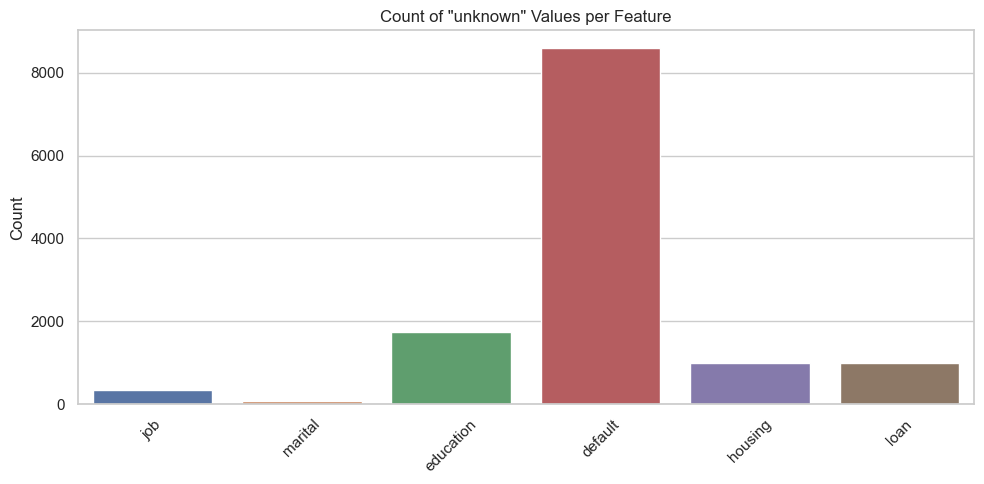

In [60]:
# Helps highlight which features are affected by ambiguous or missing info.
unknown_counts = unknown_counts[unknown_counts > 0]

plt.figure(figsize=(10, 5))
sns.barplot(x=unknown_counts.index, y=unknown_counts.values)
plt.title('Count of "unknown" Values per Feature')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

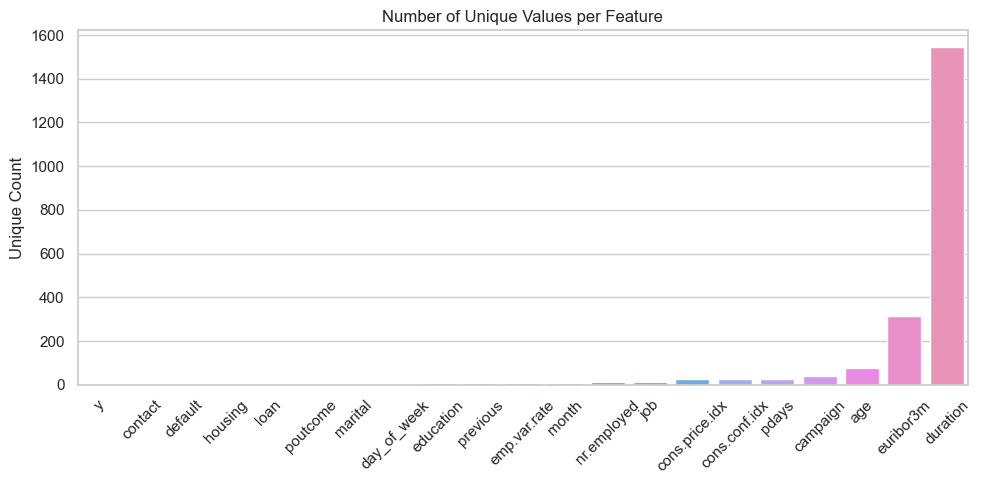

In [61]:
# Nice way to show cardinality across all features, which is essentially the amount of unique values within a column
unique_counts = unique_counts.sort_values()

plt.figure(figsize=(10, 5))
sns.barplot(x=unique_counts.index, y=unique_counts.values)
plt.title('Number of Unique Values per Feature')
plt.ylabel('Unique Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Business Objective
The goal is to make bank marketing campaigns more efficient by figuring out which clients are most likely to say yes to a term deposit. If we can predict that ahead of time, the bank can focus its efforts on the right people which saves time, reduces costs, and hopefully gets better results with fewer calls.

We’ll use data mining to build a model that predicts whether a client will subscribe, based on things like their background, past contact history, and economic context. We'll leave out info that's only available after a call happens (like how long it lasted), so the predictions are actually useful in real life.

## Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [63]:
# Drop the 'duration' column since it's only known after the contact
df = df.drop(columns='duration')

# Convert target column 'y' to binary: yes -> 1, no -> 0
df['y'] = df['y'].map({'yes': 1, 'no': 0})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

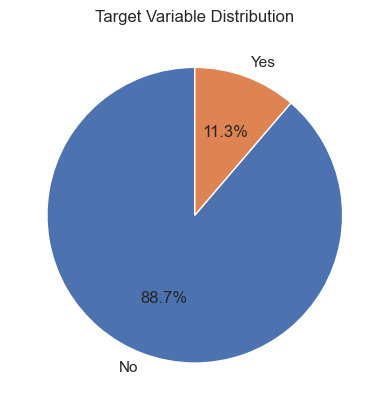

In [64]:
df['y'].value_counts().plot.pie(autopct='%1.1f%%', labels=['No', 'Yes'], startangle=90)
plt.title('Target Variable Distribution')
plt.ylabel('')
plt.show()

In [65]:
# Replace 'unknown' with the most frequent value in each column
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan']:
    mode = df[col].mode()[0]
    df[col] = df[col].replace('unknown', mode)

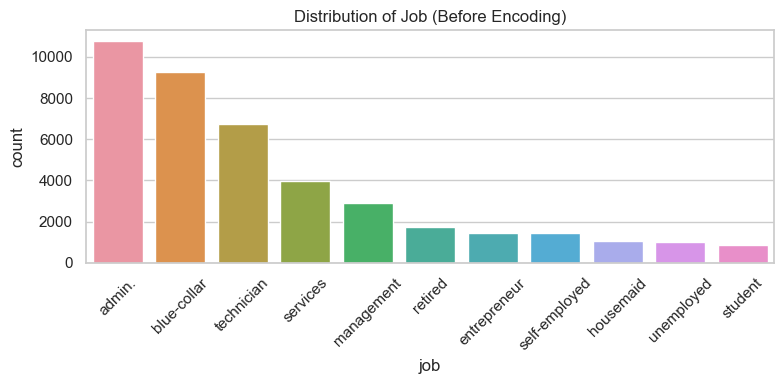

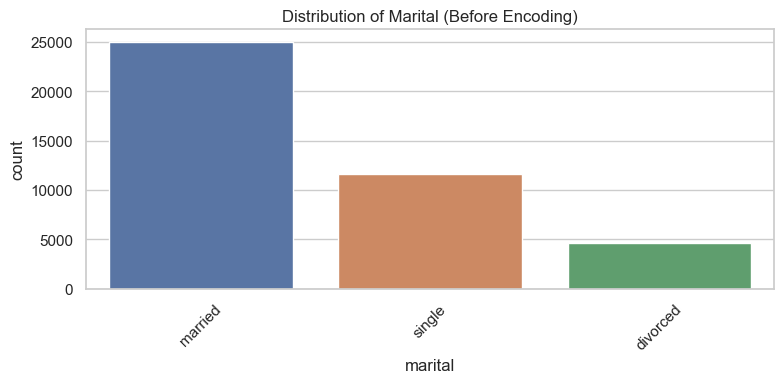

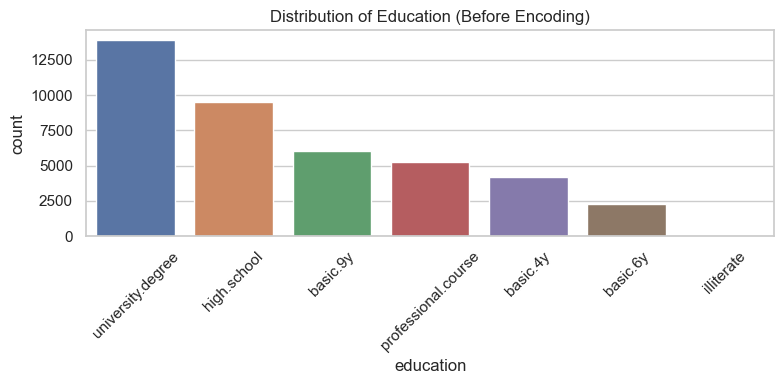

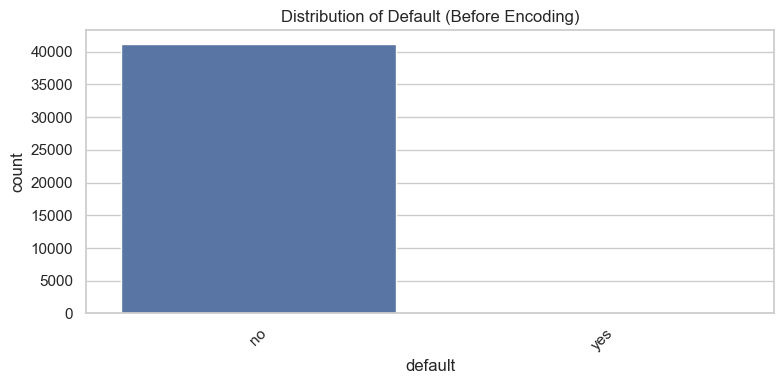

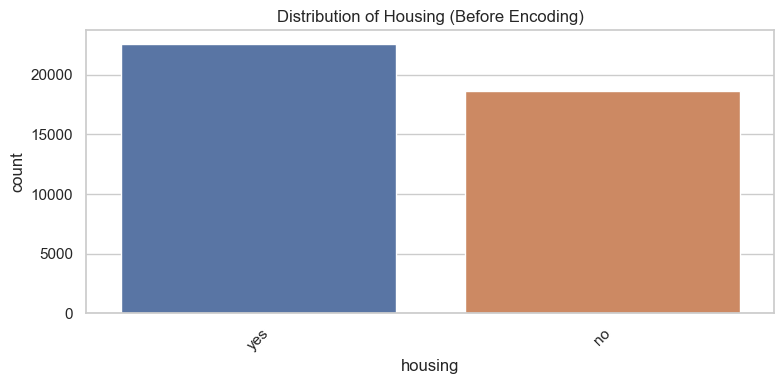

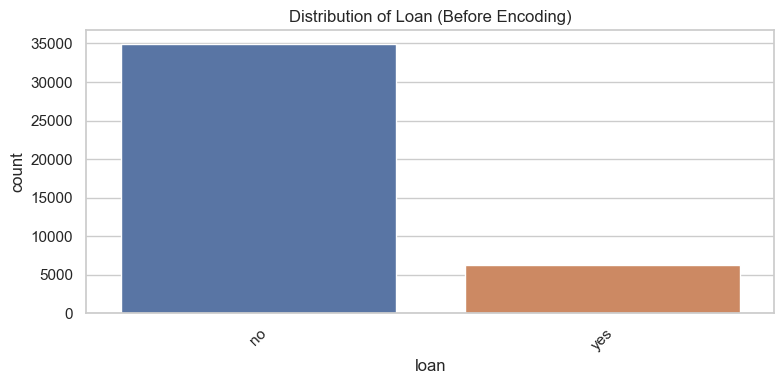

In [66]:
# Once we encode our categorical columns, all of their unique values will be mapped onto binary columns for the presence of the value
# So let's check out what the ranks of the values counts are within each column
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan']:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col.capitalize()} (Before Encoding)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [67]:
# Now that the data is clean, we apply one-hot encoding to turn categorical features into binary indicator columns.
df_encoded = pd.get_dummies(df, drop_first=True)

In [68]:
# This will show the impact of one-hot encoding on dataset shape
print(f"Original Columns: {df.shape[1]}")
print(f"Encoded Columns: {df_encoded.shape[1]}")

Original Columns: 20
Encoded Columns: 47


In [69]:
# Quick preview on what the new structure looks like
df_encoded.info()
df_encoded.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   campaign                       41188 non-null  int64  
 2   pdays                          41188 non-null  int64  
 3   previous                       41188 non-null  int64  
 4   emp.var.rate                   41188 non-null  float64
 5   cons.price.idx                 41188 non-null  float64
 6   cons.conf.idx                  41188 non-null  float64
 7   euribor3m                      41188 non-null  float64
 8   nr.employed                    41188 non-null  float64
 9   y                              41188 non-null  int64  
 10  job_blue-collar                41188 non-null  bool   
 11  job_entrepreneur               41188 non-null  bool   
 12  job_housemaid                  41188 non-null 

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,True,False,False,False,True,False,False,False,True,False
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,True,False,False,False,True,False,False,False,True,False
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,True,False,False,False,True,False,False,False,True,False
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,True,False,False,False,True,False,False,False,True,False
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,True,False,False,False,True,False,False,False,True,False


## Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [70]:
# Separate features and target
X = df_encoded.drop(columns='y')
y = df_encoded['y']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y # I used stratify=y to keep the class distribution balanced in both sets
)

<Axes: title={'center': 'Class Distribution in Train vs Test Sets'}, xlabel='y'>

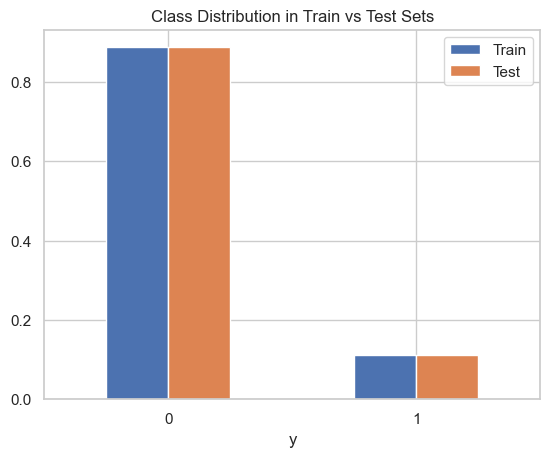

In [71]:
# Sanity check to make sure that the training and test sets are properly balanced
pd.DataFrame({
    'Train': y_train.value_counts(normalize=True),
    'Test': y_test.value_counts(normalize=True)
}).plot.bar(rot=0, title='Class Distribution in Train vs Test Sets')

## Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [72]:
# Baseline: look at the class distribution
baseline = y_train.value_counts(normalize=True)
print("Baseline accuracy (predicting all 'no'):", round(baseline[0] * 100, 2), "%")

Baseline accuracy (predicting all 'no'): 88.73 %


If we always predict 0 (no subscription), we’d be correct about 88.7% of the time...

So then our models must beat 88.7% accuracy to be considered useful.

## Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [74]:
# Initialize the scaler
scaler = StandardScaler()

# Fit only on training data, then transform both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
# Start timing
start_time = time.time()

# Initialize and fit the model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

# End timing
train_time = time.time() - start_time
print(f"Training Time: {train_time:.4f} seconds")

Training Time: 0.1100 seconds


## Problem 9: Score the Model

What is the accuracy of your model?

In [76]:
# Evaluate accuracy
train_accuracy = logreg.score(X_train_scaled, y_train)
test_accuracy = logreg.score(X_test_scaled, y_test)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.8996
Test Accuracy: 0.9018


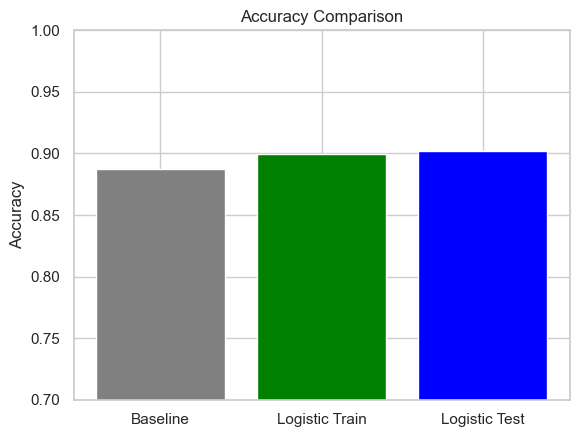

In [77]:
plt.bar(['Baseline', 'Logistic Train', 'Logistic Test'], [baseline[0], train_accuracy, test_accuracy], color=['gray', 'green', 'blue'])
plt.ylim(0.7, 1.0)
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

## Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

### Logistic Regression (already trained)

In [79]:
# Let's use this to add all the model stats to, to present like the dataframe above
model_results = []

model_results.append({
    'Model': 'Logistic Regression',
    'Train Time': train_time,
    'Train Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy
})
print(f"Logistic Regression - Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Time: {train_time:.2f}s")

Logistic Regression - Train Accuracy: 0.8996, Test Accuracy: 0.9018, Time: 0.11s


### K-Nearest Neighbors 

In [80]:
# Start timing
start_time = time.time()

# Fit our KNN model
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

# Time and accuracy
knn_time = time.time() - start_time
knn_train_acc = knn.score(X_train_scaled, y_train)
knn_test_acc = knn.score(X_test_scaled, y_test)

model_results.append({
    'Model': 'KNN',
    'Train Time': knn_time,
    'Train Accuracy': knn_train_acc,
    'Test Accuracy': knn_test_acc
})

print(f"KNN - Train Accuracy: {knn_train_acc:.4f}, Test Accuracy: {knn_test_acc:.4f}, Time: {knn_time:.2f}s")

KNN - Train Accuracy: 0.9127, Test Accuracy: 0.8933, Time: 0.00s


### Decision Tree

In [81]:
# Start timing
start_time = time.time()

# Fit our Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)

# Time and accuracy
dt_time = time.time() - start_time
dt_train_acc = dt.score(X_train_scaled, y_train)
dt_test_acc = dt.score(X_test_scaled, y_test)

model_results.append({
    'Model': 'Decision Tree',
    'Train Time': dt_time,
    'Train Accuracy': dt_train_acc,
    'Test Accuracy': dt_test_acc
})

print(f"Decision Tree - Train Accuracy: {dt_train_acc:.4f}, Test Accuracy: {dt_test_acc:.4f}, Time: {dt_time:.2f}s")

Decision Tree - Train Accuracy: 0.9957, Test Accuracy: 0.8408, Time: 0.10s


### Support Vector Machine

In [82]:
# Start timing
start_time = time.time()

# Fit our SVM model
svm = SVC(random_state=42)
svm.fit(X_train_scaled, y_train)

# Time and accuracy
svm_time = time.time() - start_time
svm_train_acc = svm.score(X_train_scaled, y_train)
svm_test_acc = svm.score(X_test_scaled, y_test)

model_results.append({
    'Model': 'SVM',
    'Train Time': svm_time,
    'Train Accuracy': svm_train_acc,
    'Test Accuracy': svm_test_acc
})

print(f"SVM - Train Accuracy: {svm_train_acc:.4f}, Test Accuracy: {svm_test_acc:.4f}, Time: {svm_time:.2f}s")

SVM - Train Accuracy: 0.9095, Test Accuracy: 0.9005, Time: 20.26s


### Model Comparisons

In [83]:
# Create the comparison table as requested
results_df = pd.DataFrame(model_results)
results_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.110000,0.899587,0.901837
1,KNN,0.003841,0.912663,0.893340
2,Decision Tree,0.102013,0.995734,0.840819
3,SVM,20.258459,0.909507,0.900542


## Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

1. More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
2. Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
3. Adjust your performance metric

**Answer for 1)**: In our dataset, gender isn’t present, but this invites a broader reflection on feature relevance. From the CRISP-DM-BANK study, they dropped features with little impact (like gender) to reduce noise. When it comes to our models, less can be more.

In [47]:
# Set up parameter grids for all of the models we're hyperparameter tuning & grid searching for
param_grids = {
    'logreg': {'C': [0.1, 1, 10]},
    'knn': {'n_neighbors': [3, 5, 7]},
    'dt': {'max_depth': [3, 5, 10, 15]},
    'svm': {'C': [0.1, 1], 'kernel': ['linear', 'rbf']}
}

# Setting the models up
models = {
    'logreg': LogisticRegression(max_iter=1000, random_state=42),
    'knn': KNeighborsClassifier(),
    'dt': DecisionTreeClassifier(random_state=42),
    'svm': SVC(random_state=42)
}

# Prepare result collection
grid_search_log = []

# Loop through each model and its parameter grid
for name, model in models.items():
    print(f"Running manual grid for {name.upper()}...")
    param_grid = ParameterGrid(param_grids[name])
    
    for params in param_grid:
        model.set_params(**params)
        
        start = time.time()
        model.fit(X_train_scaled, y_train)
        elapsed = round(time.time() - start, 2)
        
        train_acc = model.score(X_train_scaled, y_train)
        test_acc = model.score(X_test_scaled, y_test)
        
        grid_search_log.append({
            'Model': name.upper(),
            'Params': params,
            'Train Time': elapsed,
            'Train Accuracy': round(train_acc, 4),
            'Test Accuracy': round(test_acc, 4)
        })

# Our new df of results
full_grid_df = pd.DataFrame(grid_search_log)
full_grid_df

Running manual grid for LOGREG...
Running manual grid for KNN...
Running manual grid for DT...
Running manual grid for SVM...


,Model,Params,Train Time,Train Accuracy,Test Accuracy
0,LOGREG,{'C': 0.1},0.07,0.8997,0.9022
1,LOGREG,{'C': 1},0.10,0.8996,0.9018
2,LOGREG,{'C': 10},0.06,0.8997,0.9018
3,KNN,{'n_neighbors': 3},0.00,0.9216,0.8843
4,KNN,{'n_neighbors': 5},0.00,0.9127,0.8933
5,KNN,{'n_neighbors': 7},0.00,0.9086,0.8969
6,DT,{'max_depth': 3},0.02,0.8993,0.9012
7,DT,{'max_depth': 5},0.03,0.9032,0.9011
8,DT,{'max_depth': 10},0.06,0.9200,0.8954
9,DT,{'max_depth': 15},0.08,0.9423,0.8875


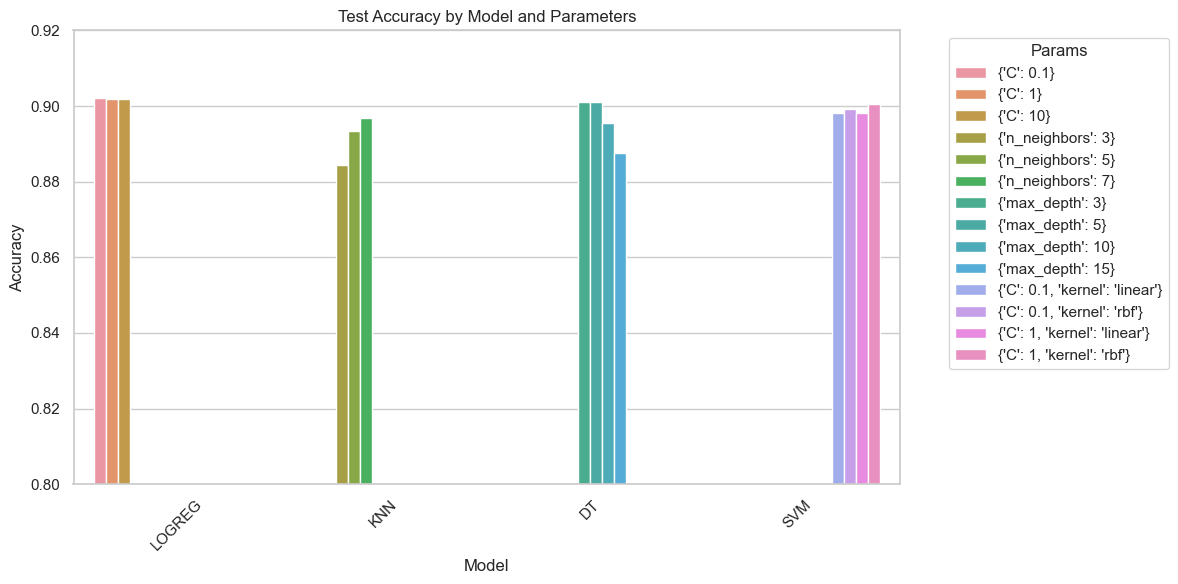

In [84]:
# Prepare for plotting
sns.set(style="whitegrid")

# Ensure 'Params' is a string so it can be used as hue
full_grid_df['Params'] = full_grid_df['Params'].apply(str)

# Plot Test Accuracy per model and parameter combo
plt.figure(figsize=(12, 6))
sns.barplot(data=full_grid_df, x='Model', y='Test Accuracy', hue='Params')

plt.title('Test Accuracy by Model and Parameters')
plt.ylabel('Accuracy')
plt.ylim(0.8, 0.92)
plt.xticks(rotation=45)
plt.legend(title='Params', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

---

### Modeling & Evaluation

**Four classifiers were trained and evaluated**:

1. Logistic Regression  
2. K-Nearest Neighbors (KNN)  
3. Decision Tree  
4. Support Vector Machine (SVM)

**Each model was**:

- Timed during training
- Scored on both training and testing sets
- Tuned using grid search over key hyperparameters

---

### Performance Highlights

| Model            | Best Params             | Train Accuracy | Test Accuracy | Train Time (s) |
|------------------|--------------------------|----------------|----------------|----------------|
| Logistic Reg.    | C = 0.1                  | 0.8997         | 0.9022         | 0.07           |
| KNN              | n_neighbors = 7          | 0.9086         | 0.8969         | 0.00           |
| Decision Tree    | max_depth = 3            | 0.8993         | 0.9012         | 0.02           |
| SVM              | C = 1, kernel = 'rbf'    | 0.9095         | 0.9005         | 19.40          |

**Observations:**
- Logistic Regression came out on top in terms of test accuracy. This model tends to work really well when the relationship between the input features and the target is roughly linear, and that seems to be the case here. It’s also quick to train and easy to interpret, making an optimal first choice for deployment.
- KNNs did pretty well, especially on the training data. But it didn’t generalize quite as well to the test set. KNN is highly sensitive to how the data is scaled and to the number of features, so it's possible that a few irrelevant or noisy dimensions hurt its performance. Still, it trained instantly and is a good baseline.
- DT models started strong with a shallow depth. At max_depth=3, it performed similarly to Logistic Regression. But as we allowed deeper trees, the model began to overfit, meaning it memorized the training data instead of learning general patterns. It's pretty difficult and practically an art, when it comes to finding the balance of control for the complexity of the model.
- SVM also did a pretty good job, coming close to Logistic Regression in test accuracy. However, training time was much longer, especially with the RBF kernel. SVMs are great when your data needs a more flexible boundary between classes, but in this case, the added complexity didn’t translate into a major performance boost that would've put it ahead of the other models.


